In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel,WhiteKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import emcee
from scipy.stats import uniform
from emcee.moves import GaussianMove
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.interpolate import Rbf


In [2]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("Updateddata.txt",names = columns)
datatab

x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']


# First dataset 
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
indices = np.arange(X1.shape[0])
X1_train, X1_test, D1_train, D1_test, E1_train, E1_test,indicestrain,indicestest = train_test_split(X1,dm1.reshape(-1, 1),em1,indices,train_size=0.8,random_state=1)

# Second dataset
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test, E2_train, E2_test = train_test_split(X2, dm2.reshape(-1,1),em2, train_size=0.8, random_state=3)

# Third dataset
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test,E3_train, E3_test = train_test_split(X3, dm3.reshape(-1,1),em3, train_size=0.8, random_state=5)

# Fourth dataset
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test,E4_train, E4_test = train_test_split(X4, dm4.reshape(-1,1),em4, train_size=0.8, random_state=7)


X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
E_train = np.concatenate((E1_train,E2_train,E3_train,E4_train))
E_test = np.concatenate((E1_test,E2_test,E3_test,E4_test))

## Noise min max model

In [63]:
bounds_lmult = ((1e-4, 10), (1e-4, 10.0), (1e-4, 10.0), (1e-4, 10.0))  # Fix l1 bounds
guess_lmult = (1,1,1,1)
guess_signal_var = 1.0
bounds_signal_var = (1e-2, 20)
nu = 1.75
noiselvl = E.mean()
noiselvlbounds = (E.min(),E.max())
Matkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=guess_lmult, length_scale_bounds=bounds_lmult, nu=nu) + WhiteKernel(noise_level=noiselvl, noise_level_bounds=noiselvlbounds)
gpr = GaussianProcessRegressor(kernel=Matkernel,normalize_y=True, n_restarts_optimizer=2,random_state=42)
gpr.fit(X_train, D_train)
print(f"Fitted Kernel: {gpr.kernel_}")

Fitted Kernel: 0.984**2 * Matern(length_scale=[0.316, 0.252, 1.39, 5.08], nu=1.75) + WhiteKernel(noise_level=0.112)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.1122857744175307. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [64]:
#### Making sure the model matches the model we examined the metrics off to ensure we are consistent

# Dfit, Dstd = gpr.predict(X1, return_std=True)
# Dtestfit,Dteststd = gpr.predict(X1_test, return_std=True)
# pointwiseparams = np.exp(gpr.kernel_.theta)
# rmse = np.sqrt(mean_squared_error(D1_test, Dtestfit))
# mae = mean_absolute_error(D1_test, Dtestfit)
# r2 = r2_score(D1_test, Dtestfit)
# adjustedr2 = 1 - (1-r2)*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1)
# fom = np.mean(np.abs(D1_test - Dtestfit)/Dteststd)
# corr, p_value = pearsonr(D1_test.ravel(), Dtestfit.ravel())
# pearsoncoeff = corr
# print("The metrics on trained model here for the Matern kernel:\n"
#       "RMSE: %0.2f, MAE: %0.2f, R²: %0.2f, Adjusted R²: %0.2f, FOM: %0.2f, Pearson Coefficient: %0.2f" %
#       (rmse, mae, r2, adjustedr2, fom, pearsoncoeff))

# columns = ['Rational Quadratic', 'ExpSineSquared', 'Laplacian', 'RBF','Matern']
# print("The metrics we had in our previous section = ")
# whitekernelerrorminmax = pd.read_csv(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\ModelMetrics\WhiteKernelwitherrorminmax.csv", names=columns)
# print(whitekernelerrorminmax.iloc[:, 4])

## Peak Param of MCMC

In [72]:
def log_prior(theta):
    return np.sum(uniform(loc=0.01, scale=4.99).logpdf(theta))
def log_posterior(theta,gpr):

    ### get rid before putting through log
    if np.any(theta <= 0): 
        return -np.inf

    theta = np.log(theta)  

    if not np.isfinite(theta).all():  
        return -np.inf

    real_theta = np.exp(theta)

    lp = log_prior(real_theta)  

    if not np.isfinite(lp):
        return -np.inf

    ll = gpr.log_marginal_likelihood(theta)


    if not np.isfinite(ll):  
        return -np.inf

    return lp + ll
bounds_lmult = ((1e-4, 10), (1e-4, 10.0), (1e-4, 10.0), (1e-4, 10.0))  
guess_lmult = (1,1,1,1)
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)
nu = 1.75
Matkernel = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * Matern(length_scale=guess_lmult, length_scale_bounds=bounds_lmult, nu=nu)

### Get point estimate for initial starting point MCMC
gpr1 = GaussianProcessRegressor(kernel=Matkernel, alpha=E_train**2,normalize_y=True, n_restarts_optimizer=30,random_state=42)
gpr1.fit(X_train, D_train)
Dfit, Dstd = gpr1.predict(X1, return_std=True)
Dtestfit,Dteststd = gpr1.predict(X1_test, return_std=True)
params = []
for j in range(5):
    params.append(np.exp(gpr1.kernel_.theta[j]))
print(f"Point estimates with Matern Kernel = {params}")

### Running MCMC algo

np.random.seed(42)
ndim = len(params)
nwalkers = ndim*4 
mean = np.array(params)
cov_matrix = np.diag(2*np.array(params))
### Where we start sampling. I take the absolute value here because I want my parameters to be positive
initial_pos = np.abs(np.random.multivariate_normal(mean, cov_matrix, nwalkers)) 
cov = 1e-2
### try cov = 1e-2
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args= (gpr1,),moves = GaussianMove(cov=cov))
nsteps = 500
samples = sampler.run_mcmc(initial_pos, nsteps, progress = True)

acceptance_fraction = sampler.acceptance_fraction
burnin = 100
thin = 15
print(f"acceptance fraction = {acceptance_fraction.mean()}")

Point estimates with Matern Kernel = [0.8472284268279076, 0.28242888703172475, 0.7979297800004849, 1.4668235969874241, 4.208967727852938]


  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\seanw\anaconda3\Lib\site-packages\emcee\moves\mh.py:58: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = new_log_probs - state.log_prob + factors
100%|██████████| 500/500 [17:02<00:00,  2.04s/it]


acceptance fraction = 0.2682
Peak Params after MCMC with the Matern Kernel = [0.8653293538730965, 0.3310374938928339, 0.5093797424163989, 1.5864864676241477, 4.337868874887979]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [73]:
#### making gaussian kde to get the peak values

peak_values = []
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
for i in range(ndim):
    samples_i = flat_samples[:, i]
    kde = gaussian_kde(samples_i)  
    x_range = np.linspace(np.min(samples_i), np.max(samples_i), 1000)
    density = kde(x_range)
    peak = x_range[np.argmax(density)]
    peak_values.append(peak)

print(f"Peak Params after MCMC with the Matern Kernel = {peak_values}")


#### GPR built on the peak parameters

kernel = gpr1.kernel_.clone_with_theta(np.log(np.array(peak_values)))
gpr2 = GaussianProcessRegressor(kernel=kernel, alpha=E_train**2, normalize_y=True,optimizer=None)
gpr2.fit(X_train, D_train)
Dfit2, Dstd2 = gpr2.predict(X1, return_std=True)
Dfit2_test,Dstd2_test = gpr2.predict(X1_test,return_std=True)

rmse = np.sqrt(mean_squared_error(D1_test, Dfit2_test))
mae = mean_absolute_error(D1_test, Dfit2_test)
r2 = r2_score(D1_test, Dfit2_test)
adjustedr2 = 1 - (1-r2)*(len(D1_test)-1)/(len(D1_test)-X1_test.shape[1]-1)
fom = np.mean(np.abs(D1_test - Dfit2_test)/Dstd2_test)
corr, p_value = pearsonr(D1_test.ravel(), Dfit2_test.ravel())
pearsoncoeff = corr


### Testing to make sure it is the same as the examined metrics to make sure we are consistent

print("The metrics on trained model here for the Matern kernel:\n"
      "RMSE: %0.2f, MAE: %0.2f, R²: %0.2f, Adjusted R²: %0.2f, FOM: %0.2f, Pearson Coefficient: %0.2f" %
      (rmse, mae, r2, adjustedr2, fom, pearsoncoeff))

columns = ['Rational Quadratic', 'ExpSineSquared', 'Laplacian', 'RBF','Matern']
print("The metrics we had in our previous section = ")
peakparams = pd.read_csv(r"C:\Users\seanw\OneDrive\Desktop\GitHub\FYP\Final Model Code\ModelMetrics\peakparams.csv", names=columns)
print(peakparams.iloc[:, 4])


Peak Params after MCMC with the Matern Kernel = [0.8653293538730965, 0.3310374938928339, 0.5093797424163989, 1.5864864676241477, 4.337868874887979]
The metrics on trained model here for the Matern kernel:
RMSE: 0.16, MAE: 0.12, R²: 0.70, Adjusted R²: 0.67, FOM: 4.16, Pearson Coefficient: 0.86
The metrics we had in our previous section = 
0    0.155576
1    0.115591
2    0.696729
3    0.669772
4    4.155935
5    0.858652
Name: Matern, dtype: float64


## Plotting each of these

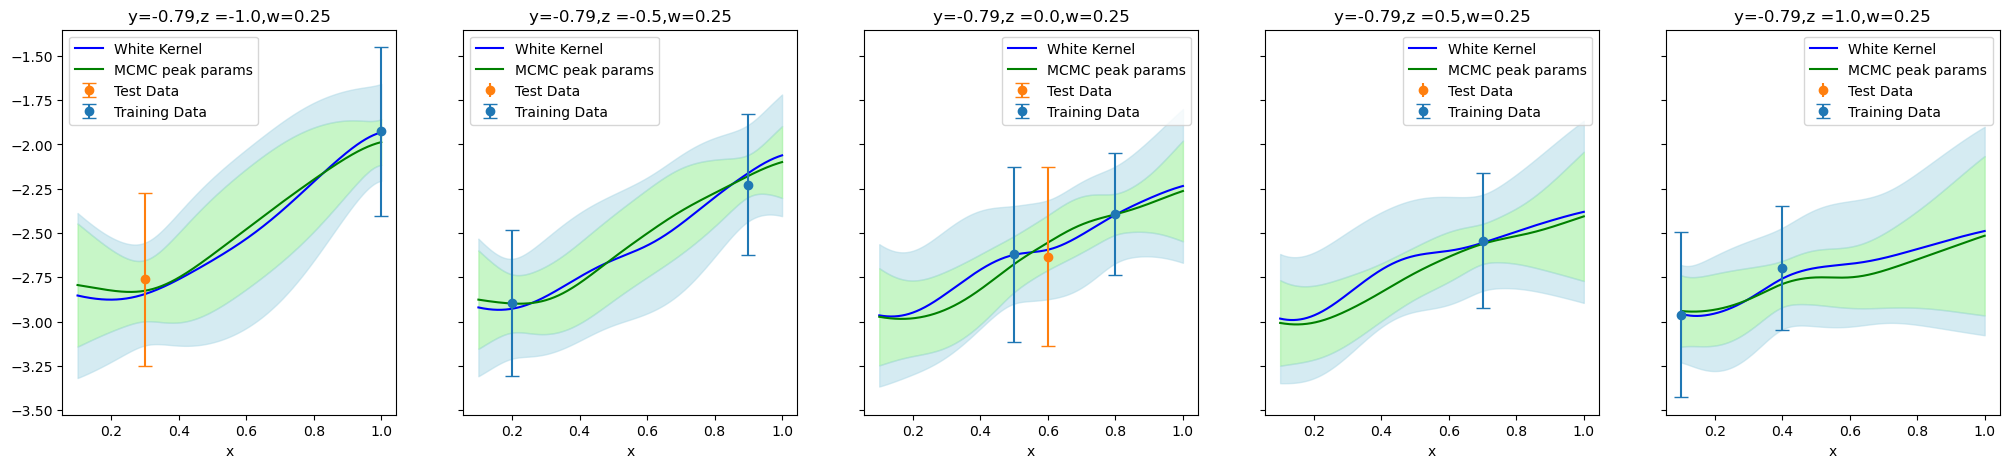

In [74]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
z1train = X1_train[:,2]
z1test = X1_test[:,2]

### interpolate on this
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2,np.pi/2,1000)
zdomain = np.linspace(-1,1,1000)

### Values data lies on
ypoints = np.linspace(-np.pi/2,np.pi/2,25)
xpoints = np.linspace(0.1,1,10)
zpoints = np.linspace(-1,1,5)
wpoints = np.linspace(0.25,1,4)

i = 6            ### Ask Sarp case i = 0  y=-1 only has -1 as corresponding z value
ypoint = ypoints[i]

j=0
wpoint = wpoints[j]

fig, axes = plt.subplots(1, 5, figsize=(25, 5),sharey=True)
for j,zpoint in enumerate(zpoints):
    Xpred = np.column_stack((xdomain,np.full(xdomain.shape,ypoint),np.full(xdomain.shape,zpoint),np.full(xdomain.shape,wpoint)))
    
    ### Note below pred_mean and pred_std correspond to the model gpr which is trained using white kerenel
    ### pred_mean2 and pred_std2 correspond to the model gpr2 which is trained using the peak params from MCMC
    pred_mean, pred_std = gpr.predict(Xpred, return_std=True)
    pred_mean2, pred_std2 = gpr2.predict(Xpred,return_std = True)
    indtrain = np.isclose(y1train, ypoint) & np.isclose(z1train, zpoint)
    indtest = np.isclose(y1test,ypoint) & np.isclose(z1test,zpoint)
    axes[j].plot(xdomain, pred_mean,color='blue',label='White Kernel')
    axes[j].plot(xdomain, pred_mean2,color='green',label='MCMC peak params')
    axes[j].fill_between(xdomain, pred_mean2 - 2*pred_std2, pred_mean2 + 2*pred_std2, alpha=0.5,color='lightgreen')
    axes[j].fill_between(xdomain, pred_mean2 - 2*pred_std2, pred_mean - 2*pred_std, alpha=0.5,color='lightblue')
    axes[j].fill_between(xdomain, pred_mean2 + 2*pred_std2, pred_mean + 2*pred_std, alpha=0.5,color='lightblue')
    axes[j].errorbar(x1test[indtest].ravel(),D1_test[indtest].ravel(),yerr=E1_test[indtest].ravel(),fmt='o', capsize=5, label='Test Data',color='#ff7f0e')
    axes[j].errorbar(x1train[indtrain].ravel(),D1_train[indtrain].ravel(),yerr=E1_train[indtrain].ravel(),fmt='o', capsize=5, label='Training Data',color='#1f77b4')
    axes[j].set_title(f"y={np.round(ypoint,2)},z ={zpoint},w={wpoint}")
    axes[j].set_xlabel("x")
    axes[j].legend()

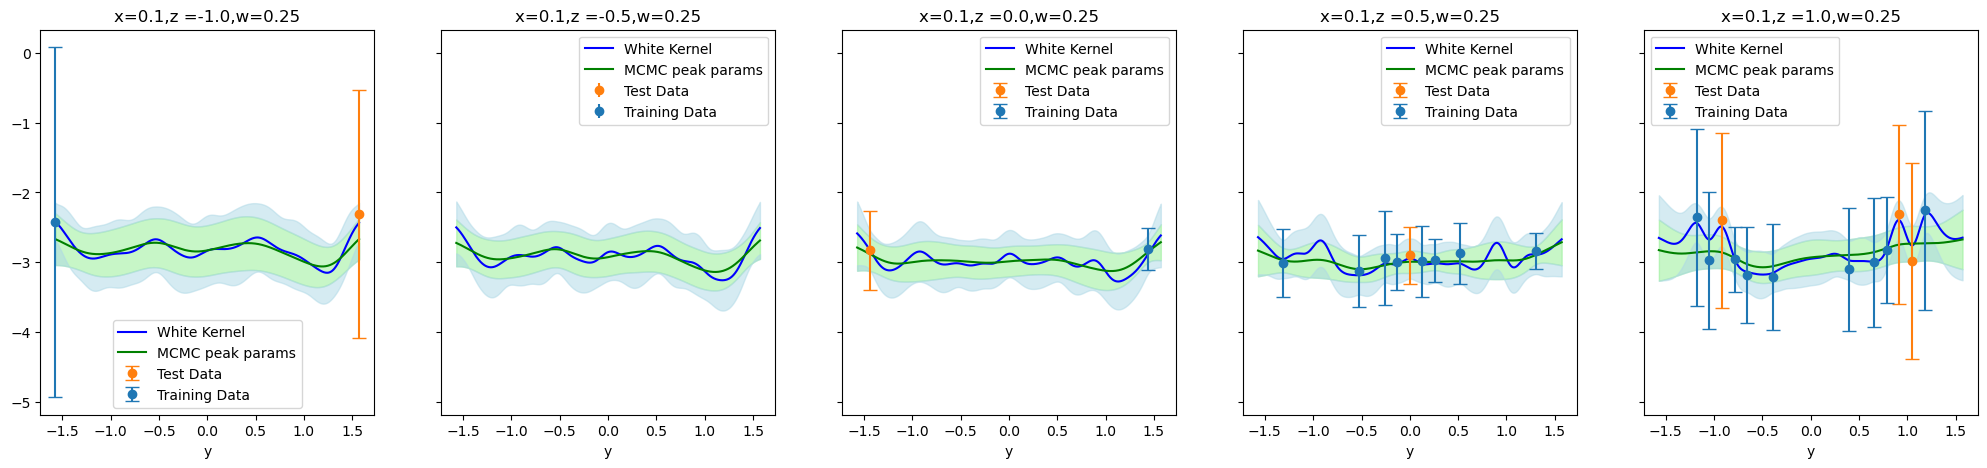

In [76]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
z1train = X1_train[:,2]
z1test = X1_test[:,2]

### interpolate on this
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2,np.pi/2,1000)
zdomain = np.linspace(-1,1,1000)

### Values data lies on
ypoints = np.linspace(-np.pi/2,np.pi/2,25)
xpoints = np.linspace(0.1,1,10)
zpoints = np.linspace(-1,1,5)
wpoints = np.linspace(0.25,1,4)

i = 0           
xpoint = xpoints[i]

j=0
wpoint = wpoints[j]

fig, axes = plt.subplots(1, 5, figsize=(25, 5),sharey=True)
for j,zpoint in enumerate(zpoints):
    Xpred = np.column_stack((np.full(ydomain.shape,xpoint),ydomain,np.full(ydomain.shape,zpoint),np.full(ydomain.shape,wpoint)))
    ### Note below pred_mean and pred_std correspond to the model gpr which is trained using white kerenel
    ### pred_mean2 and pred_std2 correspond to the model gpr2 which is trained using the peak params from MCMC
    pred_mean, pred_std = gpr.predict(Xpred, return_std=True)
    pred_mean2, pred_std2 = gpr2.predict(Xpred,return_std = True)
    indtrain = np.isclose(x1train, xpoint) & np.isclose(z1train, zpoint)
    indtest = np.isclose(x1test,xpoint) & np.isclose(z1test,zpoint)
    axes[j].plot(ydomain, pred_mean,color='blue',label='White Kernel')
    axes[j].plot(ydomain, pred_mean2,color='green',label='MCMC peak params')
    axes[j].fill_between(ydomain, pred_mean2 - 2*pred_std2, pred_mean2 + 2*pred_std2, alpha=0.5,color='lightgreen')
    axes[j].fill_between(ydomain, pred_mean2 - 2*pred_std2, pred_mean - 2*pred_std, alpha=0.5,color='lightblue')
    axes[j].fill_between(ydomain, pred_mean2 + 2*pred_std2, pred_mean + 2*pred_std, alpha=0.5,color='lightblue')
    axes[j].errorbar(y1test[indtest].ravel(),D1_test[indtest].ravel(),yerr=E1_test[indtest].ravel(),fmt='o', capsize=5, label='Test Data',color='#ff7f0e')
    axes[j].errorbar(y1train[indtrain].ravel(),D1_train[indtrain].ravel(),yerr=E1_train[indtrain].ravel(),fmt='o', capsize=5, label='Training Data',color='#1f77b4')
    axes[j].set_title(f"x={np.round(xpoint,2)},z ={zpoint},w={wpoint}")
    axes[j].set_xlabel("y")
    #axes[j].set_ylabel("Mismatch")
    axes[j].legend()

# Below this is all the different types of plotting I can do out

### Plotting the mismatch of truth - model on a 3d cube for a certain mass

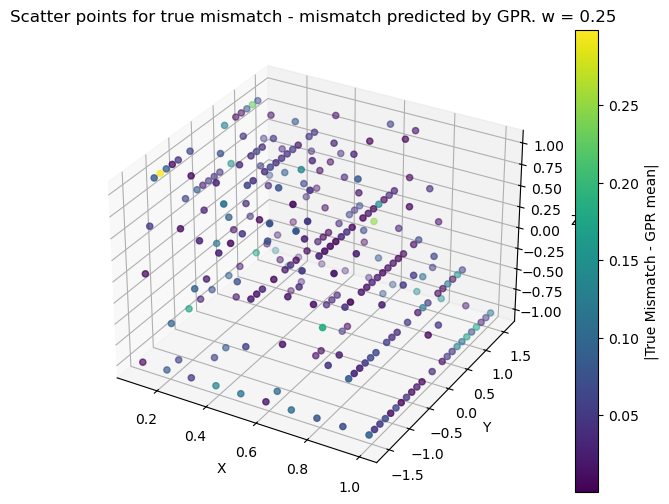

In [48]:
d3mean, d3std = gpr.predict(X1, return_std=True)

###  Here X1 is for mass 1 = 0.25, So we are holding our mass constant. In parameter space (x,y,z,w) we hold w constant and reduce to 3d

### The difference in true mismatch values to the mean of the GPR. i.e mismatch of the mismatch
mismatch = np.abs(dm1 - d3mean )

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(xm1, ym1, zm1, c=mismatch, cmap='viridis')
cb = plt.colorbar(sc, ax=ax, label='|True Mismatch - GPR mean|')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Scatter points for true mismatch - mismatch predicted by GPR. w = 0.25')
plt.show()

## Taking cross-cuts of above for each z. 
### Done first with the true mmismatch - mismatch predicted
### Then done for just predicted

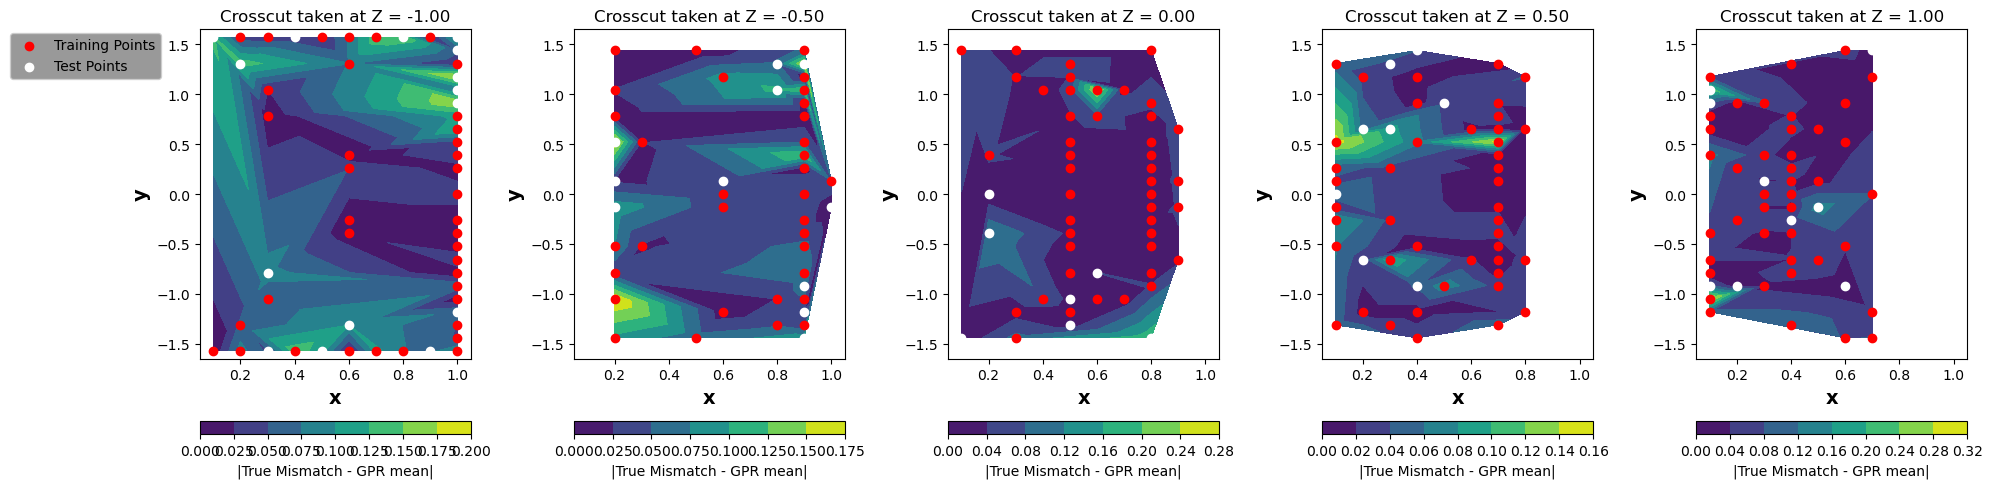

In [53]:
### interpolate on this
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2,np.pi/2,1000)
zdomain = np.linspace(-1,1,1000)

# Assuming indices, indicestrain, and indicestest have been defined beforehand, for example:
# indices = np.arange(len(xm1))

zpoints = np.linspace(-1, 1, 5)  # 5 evenly spaced z-points
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for j, zpoint in enumerate(zpoints):
    # Find those data points at the current zpoint
    inds = np.isclose(zm1, zpoint)
    
    # Get the indices of points (if you already have "indices" as np.arange(...))
    indices_z = indices[inds]
    
    # Split the indices into training and test for this z cut
    indicestrain_z = np.intersect1d(indices_z, indicestrain)
    indicestest_z = np.intersect1d(indices_z, indicestest)
    
    # Compute the mismatch (absolute difference)
    d_z = dm1[inds]
    gprmean_z = d3mean[inds]
    mismatch_z = np.abs(gprmean_z - d_z)
    
    # Extract corresponding x and y for these points
    xm1_z = xm1[inds]
    ym1_z = ym1[inds]
    
    # Plot the contour on the current axis
    contour = axes[j].tricontourf(xm1_z, ym1_z, mismatch_z, cmap='viridis')
    
    # Plot training and test points
    axes[j].scatter(xm1[indicestrain_z], ym1[indicestrain_z],
                    color='red', marker='o', label='Training Points')
    axes[j].scatter(xm1[indicestest_z], ym1[indicestest_z],
                    color='white', marker='o', label='Test Points')
    
    # Add the colorbar for this axis
    cbar = fig.colorbar(contour, ax=axes[j], orientation='horizontal', 
                        fraction=0.05, pad=0.15)
    cbar.set_label('|True Mismatch - GPR mean|')
    
    # Add legend with grey background (attached to the axis)
    if (j==0):
        leg = axes[j].legend(loc=(-0.7, 0.85))
        leg.get_frame().set_facecolor('grey')
    
    # Set labels and title for this subplot
    axes[j].set_xlabel("x", fontsize=14, weight='bold')
    axes[j].set_ylabel("y", fontsize=14, weight='bold')
    axes[j].set_title("Crosscut taken at Z = %0.2f" % (zpoint))
    axes[j].set_xlim((0.05, 1.05))
    axes[j].set_ylim((-1.65, 1.65))

plt.tight_layout()
plt.show()

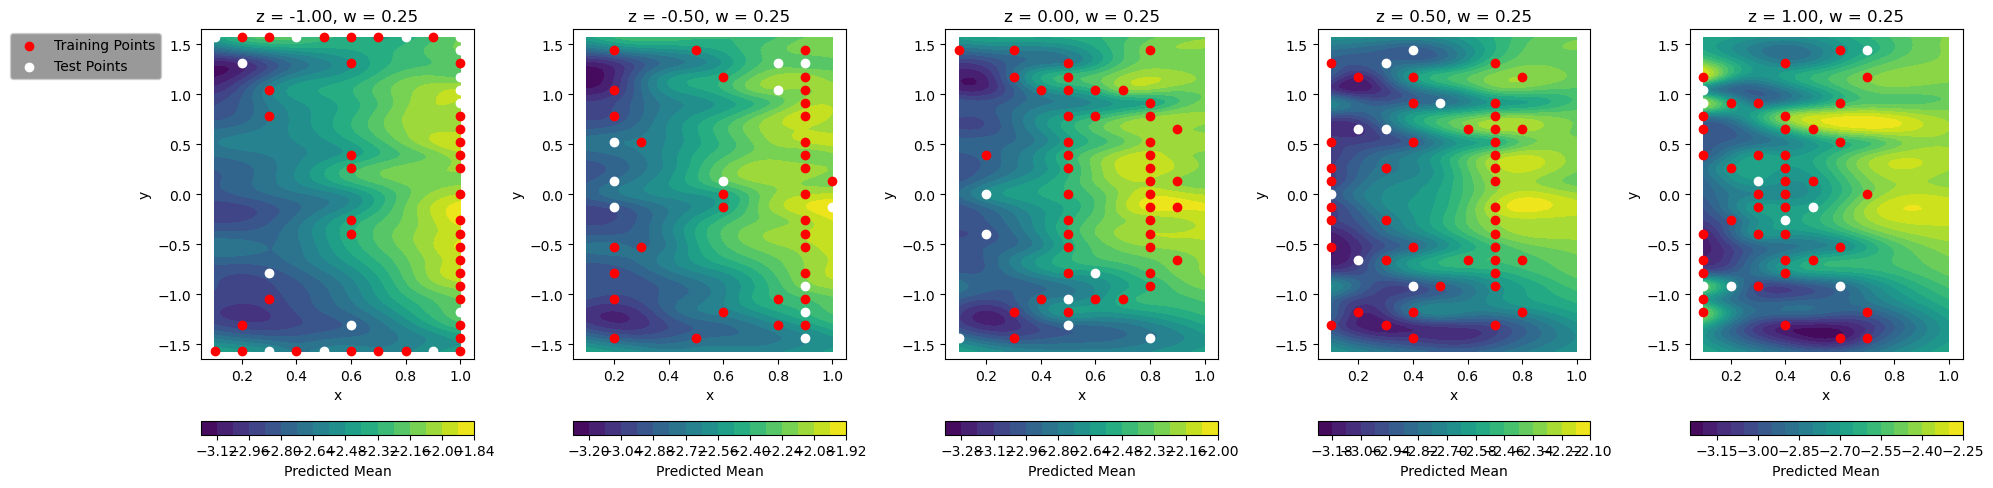

In [50]:
xdomain = np.linspace(0.1, 1, 100)
ydomain = np.linspace(-np.pi/2,np.pi/2,100)
zdomain = np.linspace(-1,1,100)

zpoints = np.linspace(-1, 1, 5) 
wpoints = np.linspace(0.25,1,4)

### Now we want to reduce it to 2d. Having (x,y,z,w) we set z and w constant

fig, axes = plt.subplots(1, 5, figsize=(20, 5))


j=0
wpoint = wpoints[j]

### Now going to make a meshgrid of x and y points so I can predict GPR and make a contour plot on the GPR values

X, Y  = np.meshgrid(xdomain,ydomain)


for i,zpoint in enumerate(zpoints):
    zpoint = zpoints[i]
    inds = np.isclose(zm1, zpoint)
    indices_z = indices[inds]
    indicestrain_z = np.intersect1d(indices_z, indicestrain)
    indicestest_z = np.intersect1d(indices_z, indicestest)
    
    ### I flatten everything to make my array stil shape (n,4)
    X2d = np.column_stack((X.ravel(),Y.ravel(),np.full(X.shape,zpoint).ravel(),np.full(X.shape,wpoint).ravel()))

    d2mean, d2std = gpr.predict(X2d, return_std=True)

    ### I reshape my mean back to the grid (100,100)
    d2mean = d2mean.reshape(X.shape)
    contour = axes[i].contourf(X, Y, d2mean, levels=20, cmap='viridis')
    cbar = fig.colorbar(contour, ax=axes[i], orientation='horizontal', label='Predicted Mean',fraction=0.05, pad=0.15)
    axes[i].scatter(xm1[indicestrain_z], ym1[indicestrain_z],color='red', marker='o', label='Training Points')
    axes[i].scatter(xm1[indicestest_z], ym1[indicestest_z],color='white', marker='o', label='Test Points')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].set_title(f'z = {zpoint:.2f}, w = {wpoint:.2f}')
    axes[i].set_xlim((0.05, 1.05))
    axes[i].set_ylim((-1.65, 1.65))
    if (i==0):
        leg = axes[i].legend(loc=(-0.7, 0.85))
        leg.get_frame().set_facecolor('grey')

plt.tight_layout()
plt.show()

### Side by side mean on a grid contour plotted and the mismatch of truth - mean

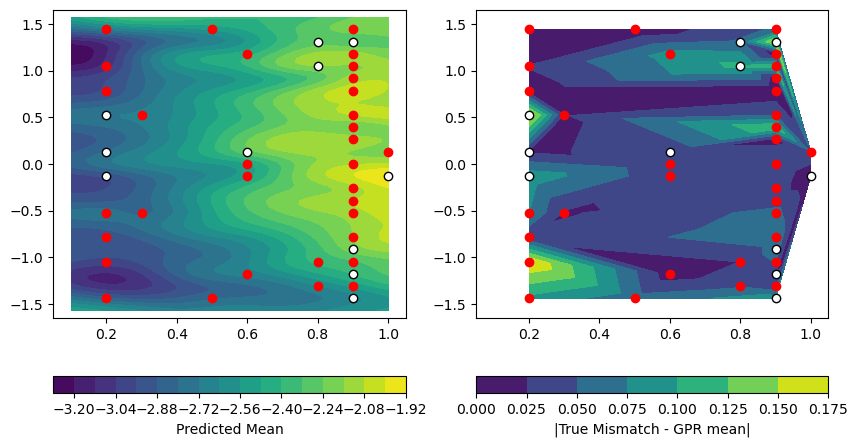

In [ ]:
xdomain = np.linspace(0.1, 1, 100)
ydomain = np.linspace(-np.pi/2,np.pi/2,100)
zdomain = np.linspace(-1,1,100)

zpoints = np.linspace(-1, 1, 5) 
wpoints = np.linspace(0.25,1,4)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))


j=0
wpoint = wpoints[j]

i = 1
zpoint = zpoints[i]


inds = np.isclose(zm1, zpoint)

# Get the indices of points (if you already have "indices" as np.arange(...))
indices_z = indices[inds]

# Split the indices into training and test for this z cut
indicestrain_z = np.intersect1d(indices_z, indicestrain)
indicestest_z = np.intersect1d(indices_z, indicestest)

# Compute the mismatch (absolute difference)
d_z = dm1[inds]
gprmean_z = d3mean[inds]
mismatch_z = np.abs(gprmean_z - d_z)

# Extract corresponding x and y for these points
xm1_z = xm1[inds]
ym1_z = ym1[inds]

X, Y  = np.meshgrid(xdomain,ydomain)

X2d = np.column_stack((X.ravel(),Y.ravel(),np.full(X.shape,zpoint).ravel(),np.full(X.shape,wpoint).ravel()))

d2mean, d2std = gpr.predict(X2d, return_std=True)

### I reshape my mean back to the grid (100,100)
d2mean = d2mean.reshape(X.shape)
contour = axes[0].contourf(X, Y, d2mean, levels=20, cmap='viridis')
cbar = fig.colorbar(contour, ax=axes[0], orientation='horizontal', label='Predicted Mean',fraction=0.05, pad=0.15)
contour = axes[1].tricontourf(xm1_z, ym1_z, mismatch_z, cmap='viridis')
cbar = fig.colorbar(contour, ax=axes[1], orientation='horizontal', fraction=0.05, pad=0.15)
cbar.set_label('|True Mismatch - GPR mean|')
for ax in axes:
    ax.scatter(xm1[indicestrain_z], ym1[indicestrain_z], color='red', marker='o', label='Training Points')
    ax.scatter(xm1[indicestest_z], ym1[indicestest_z], color='white', edgecolor='black', marker='o', label='Test Points')
    ax.set_xlim((0.05, 1.05))
    ax.set_ylim((-1.65, 1.65))

### GPR now setting y,z,w to a constant and getting the crosscuts for these

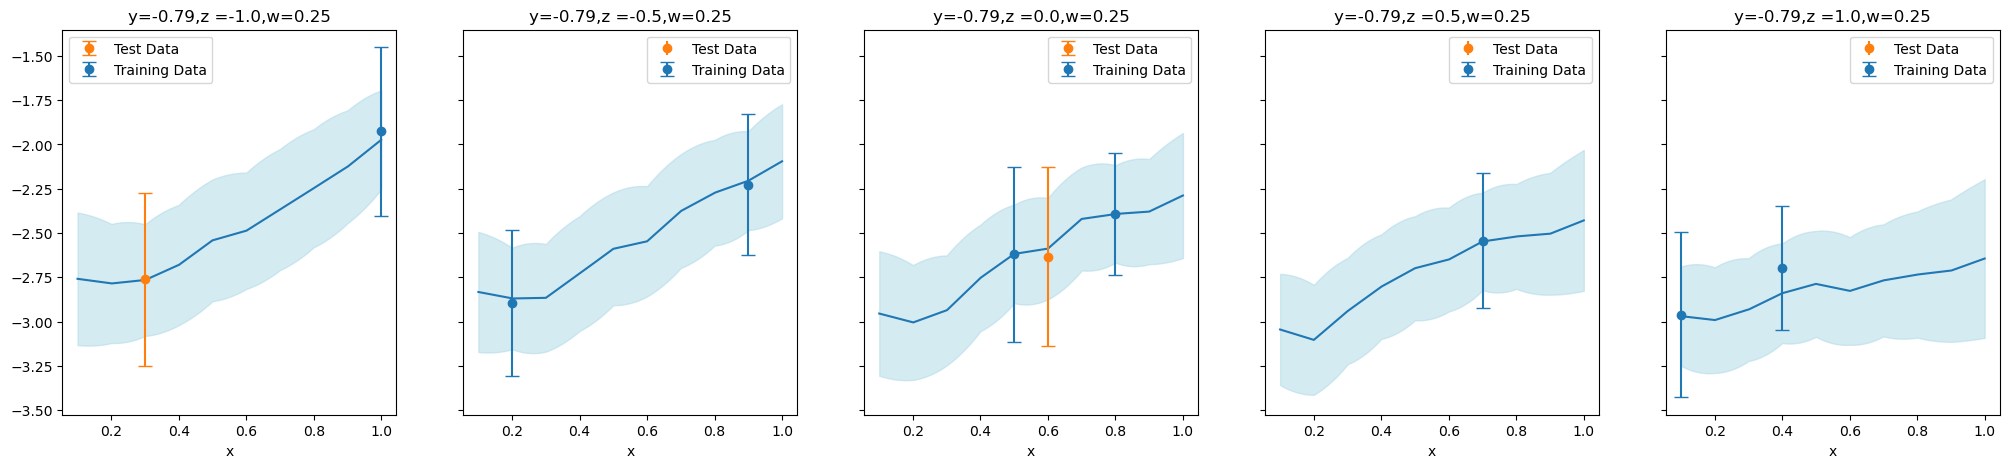

In [ ]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
z1train = X1_train[:,2]
z1test = X1_test[:,2]

### interpolate on this
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2,np.pi/2,1000)
zdomain = np.linspace(-1,1,1000)

### Values data lies on
ypoints = np.linspace(-np.pi/2,np.pi/2,25)
xpoints = np.linspace(0.1,1,10)
zpoints = np.linspace(-1,1,5)
wpoints = np.linspace(0.25,1,4)

i = 6            ### Ask Sarp case i = 0  y=-1 only has -1 as corresponding z value
ypoint = ypoints[i]

j=0
wpoint = wpoints[j]

fig, axes = plt.subplots(1, 5, figsize=(25, 5),sharey=True)
for j,zpoint in enumerate(zpoints):
    Xpred = np.column_stack((xdomain,np.full(xdomain.shape,ypoint),np.full(xdomain.shape,zpoint),np.full(xdomain.shape,wpoint)))
    pred_mean, pred_std = gpr.predict(Xpred, return_std=True)
    indtrain = np.isclose(y1train, ypoint) & np.isclose(z1train, zpoint)
    indtest = np.isclose(y1test,ypoint) & np.isclose(z1test,zpoint)
    axes[j].plot(xdomain, pred_mean)
    axes[j].fill_between(xdomain, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.5,color='lightblue')
    axes[j].errorbar(x1test[indtest].ravel(),D1_test[indtest].ravel(),yerr=E1_test[indtest].ravel(),fmt='o', capsize=5, label='Test Data',color='#ff7f0e')
    axes[j].errorbar(x1train[indtrain].ravel(),D1_train[indtrain].ravel(),yerr=E1_train[indtrain].ravel(),fmt='o', capsize=5, label='Training Data',color='#1f77b4')
    axes[j].set_title(f"y={np.round(ypoint,2)},z ={zpoint},w={wpoint}")
    axes[j].set_xlabel("x")
    #axes[j].set_ylabel("Mismatch")
    axes[j].legend()


### GPR holding x,z,w constant and getting crosscuts of these

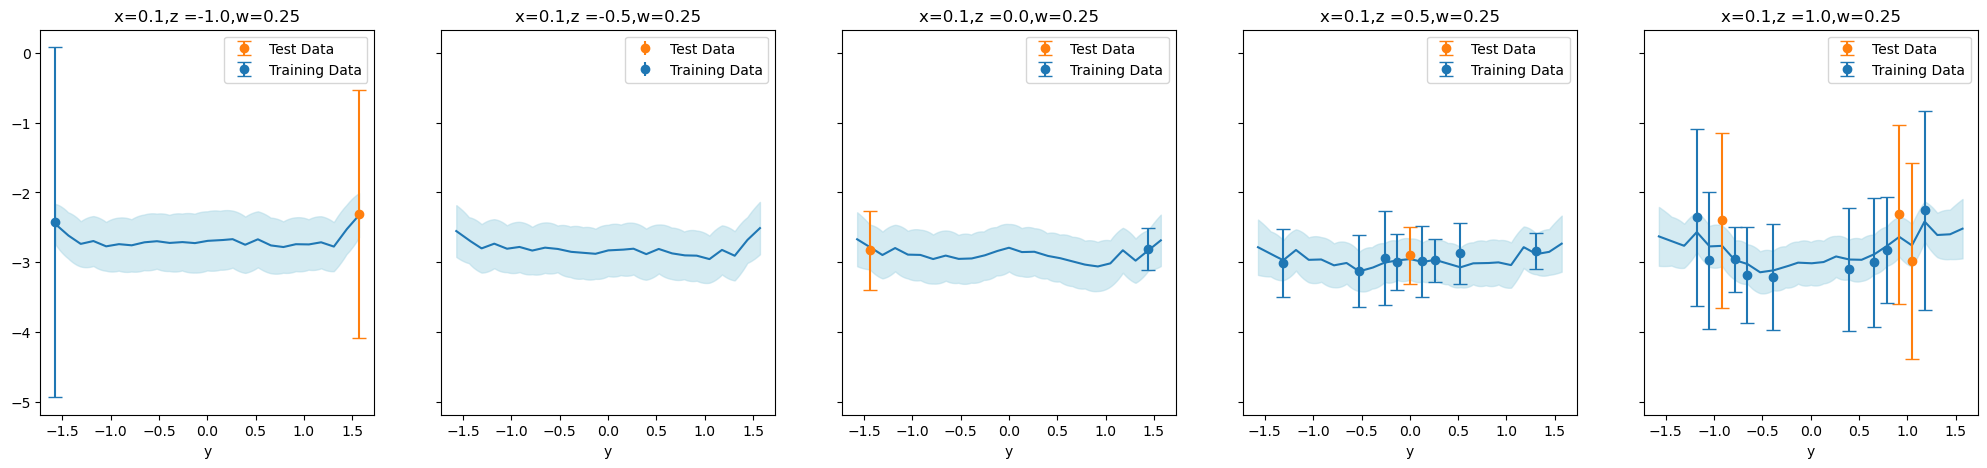

In [149]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
z1train = X1_train[:,2]
z1test = X1_test[:,2]

### interpolate on this
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2,np.pi/2,1000)
zdomain = np.linspace(-1,1,1000)

### Values data lies on
ypoints = np.linspace(-np.pi/2,np.pi/2,25)
xpoints = np.linspace(0.1,1,10)
zpoints = np.linspace(-1,1,5)
wpoints = np.linspace(0.25,1,4)

i = 0           
xpoint = xpoints[i]

j=0
wpoint = wpoints[j]

fig, axes = plt.subplots(1, 5, figsize=(25, 5),sharey=True)
for j,zpoint in enumerate(zpoints):
    Xpred = np.column_stack((np.full(ydomain.shape,xpoint),ydomain,np.full(ydomain.shape,zpoint),np.full(ydomain.shape,wpoint)))
    pred_mean, pred_std = gpr.predict(Xpred, return_std=True)
    indtrain = np.isclose(x1train, xpoint) & np.isclose(z1train, zpoint)
    indtest = np.isclose(x1test,xpoint) & np.isclose(z1test,zpoint)
    axes[j].plot(ydomain, pred_mean)
    axes[j].fill_between(ydomain, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.5,color='lightblue')
    axes[j].errorbar(y1test[indtest].ravel(),D1_test[indtest].ravel(),yerr=E1_test[indtest].ravel(),fmt='o', capsize=5, label='Test Data',color='#ff7f0e')
    axes[j].errorbar(y1train[indtrain].ravel(),D1_train[indtrain].ravel(),yerr=E1_train[indtrain].ravel(),fmt='o', capsize=5, label='Training Data',color='#1f77b4')
    axes[j].set_title(f"x={np.round(xpoint,2)},z ={zpoint},w={wpoint}")
    axes[j].set_xlabel("y")
    #axes[j].set_ylabel("Mismatch")
    axes[j].legend()

### Interpolating and getting the true crosscuts of the above higher dimensional graphs. However not as accurate at representing the GPR

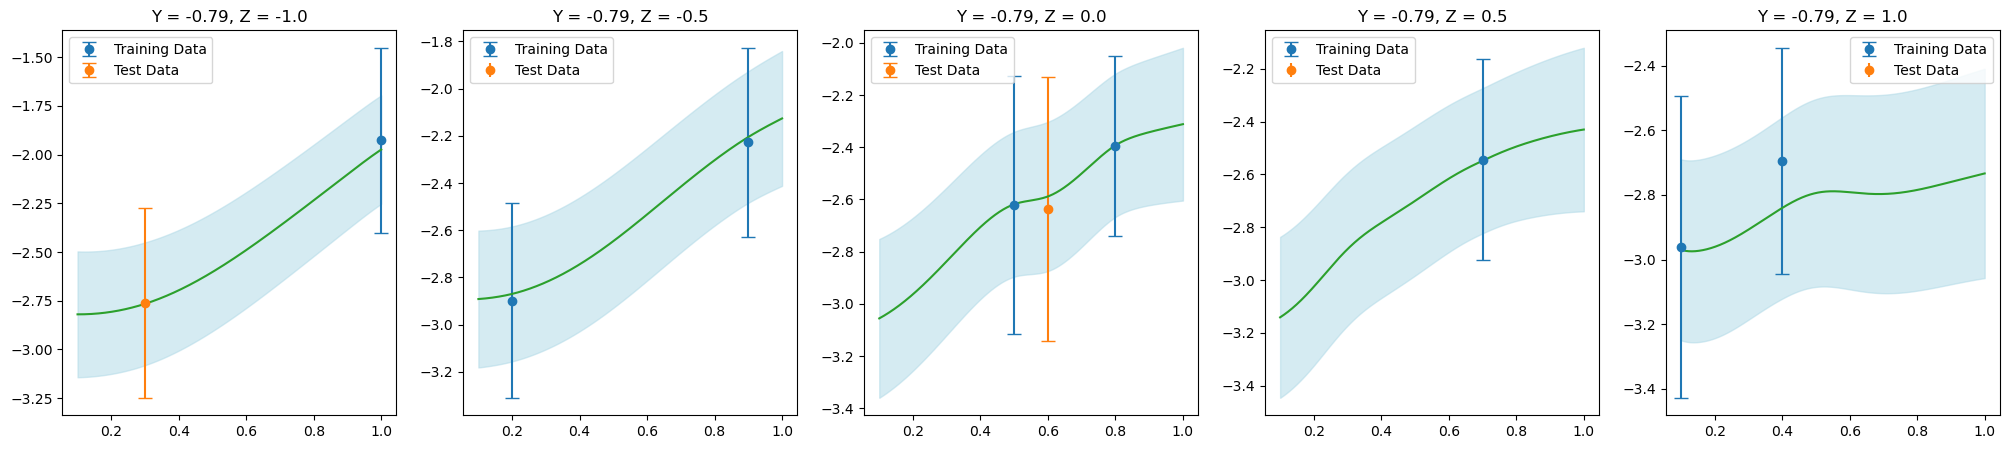

In [142]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
z1train = X1_train[:,2]
z1test = X1_test[:,2]

gprmean = Dfit
gprstd = Dstd

### interpolate on this
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2,np.pi/2,1000)
zdomain = np.linspace(-1,1,1000)

### Values data lies on
ypoints = np.linspace(-np.pi/2,np.pi/2,25)
xpoints = np.linspace(0.1,1,10)
zpoints = np.linspace(-1,1,5)

#### Fixing y and so cutting horizontally, total of 10 training and test points

i = 6            ### Ask Sarp case i = 0  y=-1 only has -1 as corresponding z value
ypoint = ypoints[i]
#print(ypoint)

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for j in range(len(zpoints)):
    zpoint = zpoints[j]
    interpdomain = np.column_stack([xm1,ym1,zm1])  ## shape 250 , 3
    cutpoints = np.column_stack([xdomain,np.full(1000,ypoint),np.full(1000,zpoint)]) ## shape 1000, 3

    ### Interpolate with RBF to give smoother results, better I think
    rbfinterp_mean = Rbf(interpdomain,gprmean, kernel='cubic')
    mean = rbfinterp_mean(cutpoints)
    rbfinterp_std = Rbf(interpdomain,gprstd, kernel = 'cubic')
    std = rbfinterp_std(cutpoints)

    
    ## Interpolating with griddata in 3d only allows linear interpolations
    # mean = griddata(interpdomain, gprmean, cutpoints, method="linear") 
    # std = griddata(interpdomain, gprstd, cutpoints, method="linear")
    indtrain = np.isclose(y1train, ypoint) & np.isclose(z1train, zpoint)
    indtest = np.isclose(y1test,ypoint) & np.isclose(z1test,zpoint)
    axes[j].errorbar(x1train[indtrain].ravel(),D1_train[indtrain].ravel(),yerr=E1_train[indtrain].ravel(),fmt='o', capsize=5, label='Training Data')
    axes[j].errorbar(x1test[indtest].ravel(),D1_test[indtest].ravel(),yerr=E1_test[indtest].ravel(),fmt='o', capsize=5, label='Test Data')
    axes[j].plot(xdomain,mean)
    axes[j].set_title(f"Y = {np.round(ypoint,2)}, Z = {np.round(zpoint,2)}")
    axes[j].fill_between(xdomain,mean-2*std,mean+2*std,alpha =0.5,color='lightblue')
    axes[j].legend()

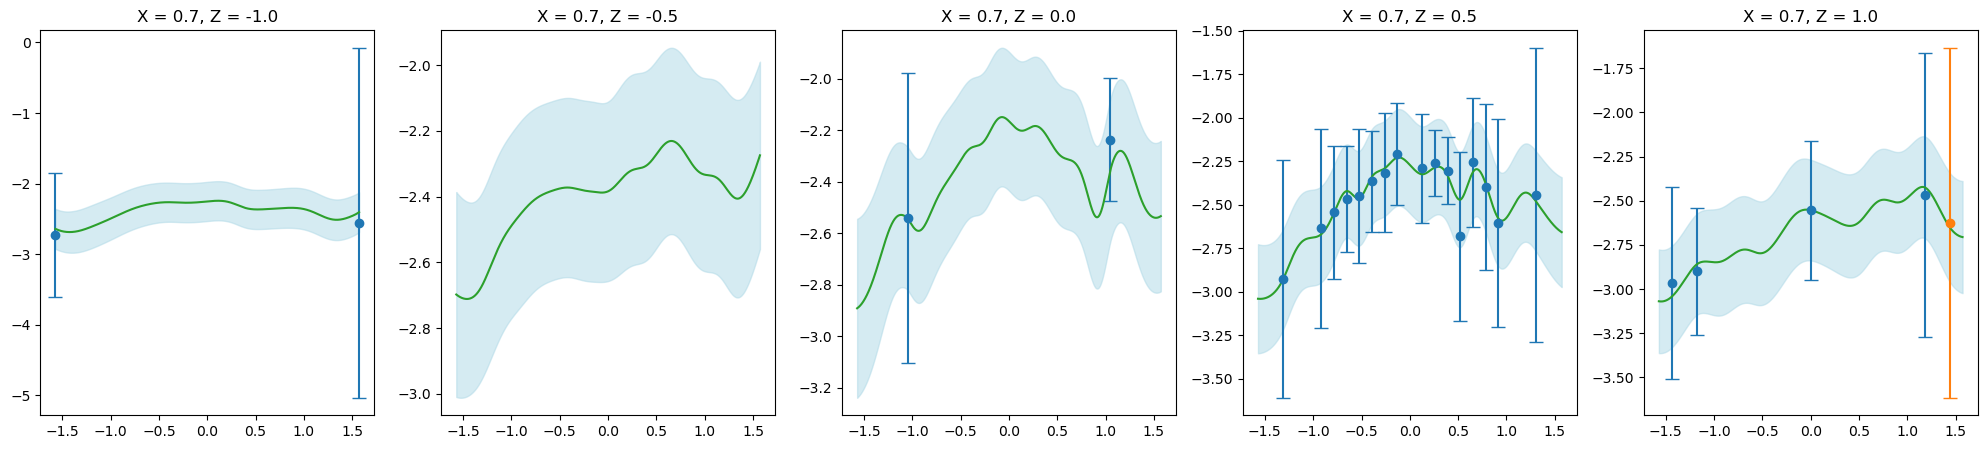

In [146]:
x1train = X1_train[:,0]
y1train = X1_train[:,1]
x1test = X1_test[:,0]
y1test = X1_test[:,1]
z1train = X1_train[:,2]
z1test = X1_test[:,2]

gprmean = Dfit
gprstd = Dstd

### interpolate on this
xdomain = np.linspace(0.1, 1, 1000)
ydomain = np.linspace(-np.pi/2,np.pi/2,1000)
zdomain = np.linspace(-1,1,1000)

### Values data lies on
ypoints = np.linspace(-np.pi/2,np.pi/2,25)
xpoints = np.linspace(0.1,1,10)
zpoints = np.linspace(-1,1,5)

#### Fixing x means taking a vertical cut, total of 25 training and test points

i = 6           ### Ask Sarp case i = 0  y=-1 only has -1 as corresponding z value
xpoint = xpoints[i]


fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for j in range(len(zpoints)):
    zpoint = zpoints[j]
    interpdomain = np.column_stack([xm1,ym1,zm1])  ## shape 250 , 3
    cutpoints = np.column_stack([np.full(1000,xpoint),ydomain,np.full(1000,zpoint)]) ## shape 1000, 3
    ### RBF interpolation
    rbfinterp_mean = Rbf(interpdomain,gprmean, kernel='cubic')
    mean = rbfinterp_mean(cutpoints)
    rbfinterp_std = Rbf(interpdomain,gprstd, kernel = 'cubic')
    std = rbfinterp_std(cutpoints)

    ### Linear Interpolation
    # mean = griddata(interpdomain, gprmean, cutpoints, method="linear")
    # std = griddata(interpdomain, gprstd, cutpoints, method="linear")
    indtrain = np.isclose(x1train, xpoint) & np.isclose(z1train, zpoint)
    indtest = np.isclose(x1test,xpoint) & np.isclose(z1test,zpoint)
    axes[j].errorbar(y1train[indtrain].ravel(),D1_train[indtrain].ravel(),yerr=E1_train[indtrain].ravel(),fmt='o', capsize=5, label='Training Data')
    axes[j].errorbar(y1test[indtest].ravel(),D1_test[indtest].ravel(),yerr=E1_test[indtest].ravel(),fmt='o', capsize=5, label='Test Data')
    axes[j].plot(ydomain,mean)
    axes[j].set_title(f"X = {np.round(xpoint,2)}, Z = {np.round(zpoint,2)}")
    axes[j].fill_between(ydomain,mean-2*std,mean+2*std,alpha =0.5,color = 'lightblue')